# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

- To identify students who might need early intervention before they fail to graduate, I think it is a classification problem, which distinguish those who need early intervention or those not.
- By definition, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known. 
- So to discriminate which group of students need early intervention before they fail to graduate, we need sufficient machine learning algorithm to classify them. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import seaborn as sns
%matplotlib inline

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
student_data[student_data['passed'] == 'no'].count()[0]

130

In [3]:
student_data[student_data['passed'] == 'yes'].count()[0]

265

In [4]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = student_data.shape[1]

# TODO: Calculate passing students
n_passed = student_data[student_data['passed'] == 'yes'].count()[0]

# TODO: Calculate failing students
n_failed = student_data[student_data['passed'] == 'no'].count()[0]

# TODO: Calculate graduation rate
grad_rate = float(n_passed)/(float(n_passed) + float(n_failed))*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 31
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [5]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [6]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [7]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


In [8]:
y_all.head()

0     no
1     no
2    yes
3    yes
4    yes
Name: passed, dtype: object

/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


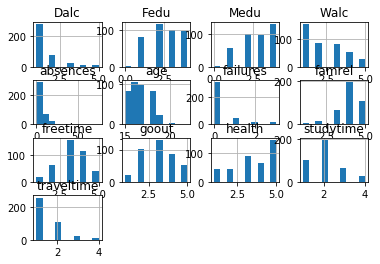

In [9]:
# Univariate Histogram
import matplotlib.pyplot as plt
student_data.hist()
plt.show()

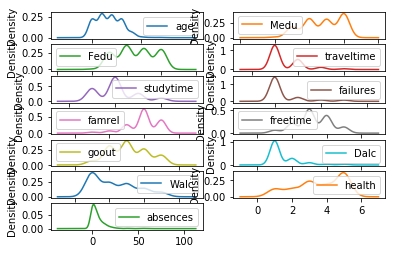

In [10]:
# Univariate Density Plots
student_data.plot(kind='density', subplots=True, layout=(7,2), sharex=False)
plt.show()

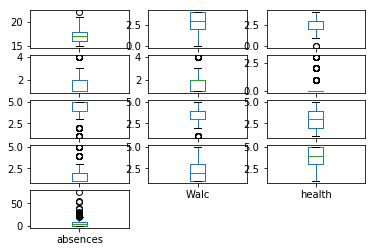

In [11]:
student_data.plot(kind='box', subplots=True, layout=(5,3), sharex=False, sharey=False)
plt.show()

In [30]:
import numpy as np
correlations = student_data.corr()

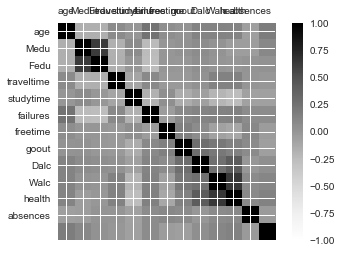

In [31]:
names= ['age',  'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'freetime', 
        'goout', 'Dalc', 'Walc', 'health', 'absences']
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

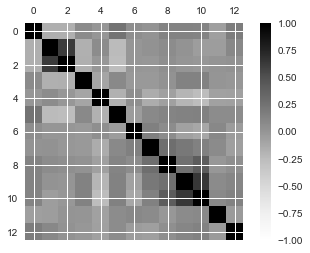

In [32]:
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

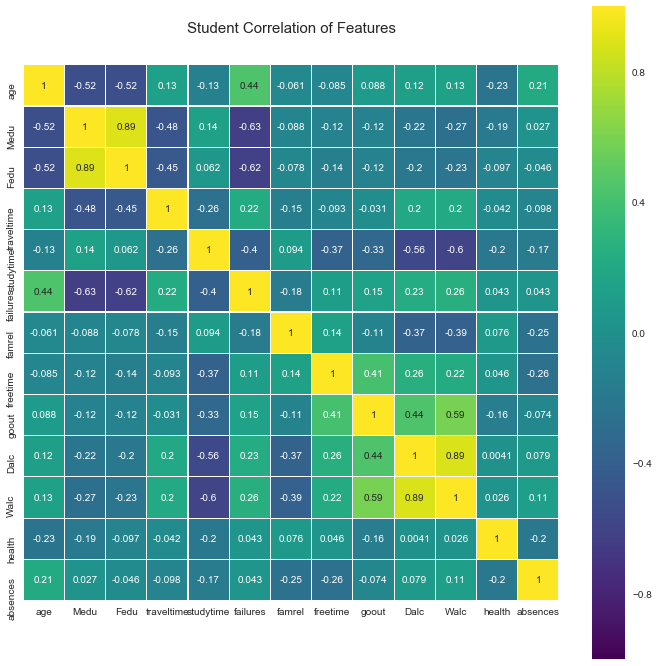

In [33]:

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Student Correlation of Features', y=1.05, size=15)
sns.heatmap(correlations.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

In [26]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
model = ExtraTreesClassifier()
model.fit(X_all, y_all)
print(model.feature_importances_)


[ 0.01231472  0.01254007  0.00981062  0.01479217  0.03219241  0.01473362
  0.00610465  0.00690714  0.02150669  0.0048386   0.0066301   0.03614671
  0.0270326   0.01516336  0.01583781  0.01765593  0.01327906  0.01599752
  0.00955902  0.00736274  0.01865611  0.02339749  0.00887133  0.0212639
  0.01475709  0.01009641  0.01528292  0.01603875  0.01328734  0.01522991
  0.02562565  0.03513958  0.06395924  0.02924245  0.02001376  0.02055606
  0.02352763  0.02318979  0.01604864  0.02268703  0.02823524  0.03544978
  0.0296351   0.03931173  0.02474304  0.03861266  0.02618125  0.04055458]


failures
absences
goout
age
studytime
Fedu
Medu
Walc
famrel
freetime


/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


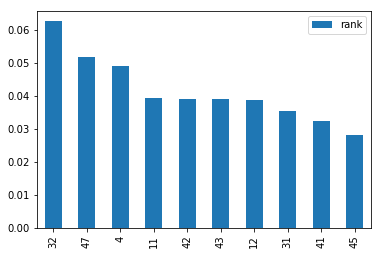

In [15]:
# find top 10 most importance features 
df = pd.DataFrame(model.feature_importances_, columns=['rank'])
df.sort('rank', ascending =False)

l = []
for i in X_all.columns:
    l.append(i)

# display them
for i in [32, 47, 43, 4, 31, 12, 11, 45, 41, 42]:
    print l[i]

# plot them
df.sort('rank', ascending=False).head(10).plot(kind='bar')
plt.show()

/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


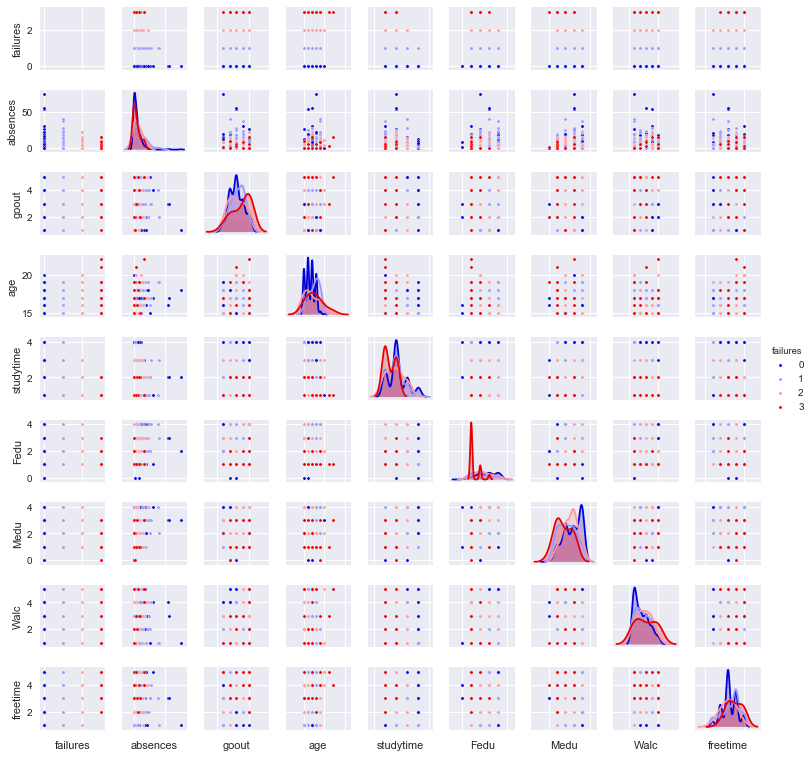

In [35]:
g = sns.pairplot(X_all[[u'failures', u'absences', u'goout', u'age', u'studytime', u'Fedu', u'Medu',
       u'Walc', u'freetime']], hue='failures', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [16]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import ShuffleSplit, train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=0)


# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


/Users/gaojianxun/ANACONDA43/anaconda/envs/MLND/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
X_train[:100].head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
63,1,0,1,0,16,0,1,1,0,0,...,1,1,0,3,4,4,2,4,4,2
245,1,0,0,1,16,0,1,1,0,0,...,1,1,0,4,3,3,1,1,4,6
154,1,0,1,0,17,0,1,1,0,0,...,1,0,1,4,2,1,1,1,4,0
311,1,0,1,0,19,0,1,1,0,0,...,0,1,1,3,4,1,1,1,2,20
81,1,0,0,1,15,0,1,1,0,0,...,1,1,0,5,3,2,1,2,5,4


In [37]:
y_train[:100].head()

63      no
245    yes
154    yes
311    yes
81     yes
Name: passed, dtype: object

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

### Stochastic Gradient Descent (SGDC)
- One real-world application:
    By far it is the most common way to optimize neural networks. Almost every state-of-the-art Deep Learning libary contains implementation of it.
- The strengths of the model
    1. Efficiency
    2. Ease of implementation (lots of opportunities for code tuning)
    SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing.
- The weaknesses of the model
    1. SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations
    2. SGD is sensitive to feature scaling     
- A good condidate for:
    Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

### Bagging (Bootstrap aggregating)
proposed by Leo Breiman in 1994 to improve the classification by combining classifications of randomly generated training sets.    
- One real-world application
    Ozone data. [See AdaBoost]

- The strengths of the model
    1. smoothing out the variance and hence reducing the test error
    2. reducing the variance of unstable procedures like trees, leading to imporved prediction(Breiman, 1996).
    3. As provided a way to reduce overfitting, it work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

- The weaknesses of the model
    By increasing the size of the training set one can't improve the model predictive force, but just decrease the variance, narrowly tuning the prediction to expected outcome.
        
- A good condidate for
    a useful technique to reduce the variance of a model by drawing random bootstrap samples from the training set and combining the individually trained classifiers via majority vote

### AdaBoost (Adaptive Boosting)
- One real-world application
    The AdaBoost algorithm has achieved great success in the past ten years. It has demonstrated excellent experimental performance both on benchmark datasets and real applications [E. Bauer and R. Kohavi. An empirical comparison of voting classification algorithms: Bagging, boosting and variants. MachineLearning, 36:105–139, 1999., T. Dietterich. An experimental comparison of three methods for constructing ensembles of decision trees: Bagging, boosting and randomization. Machine Learning, 40:139–157,2000., P. Viola and M. Jones. Rapid object detection using a boosted cascade of simple features. In IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2001.]
- The strengths of the model
     1. is an iterative procedure that tries to approximate the Bayes classifier by combining many weak classifiers.
     2. to be equivalent to a forward stagewise additive modeling algorithm that minimizes the exponential loss.
     3. the multi-class AdaBoost algorithm is equivalent to a forward stagewise additive modeling algorithm that minimizes a novel exponential loss for multi-class classification[J. Zhu, H. Zou, S. Rosset, T. Hastie. “Multi-class AdaBoost”, 2009.]
- The weaknesses of the model
    It can be sensitive to noisy data and outliers. In some problems, however, it can be less susceptible to the overfitting problem than most learning algorithms. The GRT AdaBoost algorithm does not currently support null rejection, although this will be added at some point in the near future. [reference](http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost)
        
- A good condidate for:
     It is a powerful classifier that works well on both basic and more complex recognition problems. AdaBoost works by creating a highly accurate classifier by combining many relatively weak and inaccurate classifiers. AdaBoost therefore acts as a meta algorithm, which allows you to use it as a wrapper for other classifiers.


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [38]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [43]:
# TODO: Import the three supervised learning models from sklearn

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
C=100.
# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = KNeighborsClassifier() # (n_neighbors=2)
clf_C = SGDClassifier() #(loss="hinge", penalty="l2")
clf_D = svm.SVC()
clf_E = DecisionTreeClassifier()
clf_F = AdaBoostClassifier(n_estimators=100)
clf_G = GradientBoostingClassifier() # (n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_H = RandomForestClassifier() # (n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf_I = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
clf_I_1 = BaggingClassifier(clf_E, max_samples=0.5, max_features=0.5)
clf_J = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train
y_train_300 = y_train

for clf in [clf_A, clf_B, clf_C, clf_D,clf_E, clf_F,clf_G, clf_H, clf_I, clf_J, clf_l1_LR, clf_l2_LR]:
    # print clf
    # TODO: Execute the 'train_predict' function for each classifier and each training set size
    train_predict(clf, X_train_100, y_train_100, X_test, y_test)
    train_predict(clf, X_train_200, y_train_200, X_test, y_test)
    train_predict(clf, X_train_300, y_train_300, X_test, y_test)

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0008 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 0.8550.
Made predictions in 0.0008 seconds.
F1 score for test set: 0.7481.
Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0009 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.8321.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.7132.
Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0008 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.8088.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.7500.
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0006 seconds
Made predictions in 0.0016 seconds.
F1 score for training set: 0.7972.
Made predictions in 0.0016 seconds.
F1 score for test set: 0.7068.
Training a KNeighborsClassifier using a training set size of 200. . .


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - SGD  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0006 s         |      0.0002 s          |    0.7805        |    0.7662       |
| 200               |        0.0006 s         |      0.0003 s          |    0.7554        |    0.7313       |
| 300               |        0.0009 s         |      0.0002 s          |    0.8203        |    0.7704       |

** Classifer 2 - AdaBoost  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.1803 s            |      0.0060 s          |    0.9922        |     0.7344      |
| 200               |     0.1886 s            |      0.0065 s          |    0.8849        |     0.7761      |
| 300               |     0.2036 s            |      0.0067 s          |    0.8761        |     0.7820      |

** Classifer 3 - Bagging  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0128 s            |     0.0093 s           |     0.8169       |     0.8000      |
| 200               |     0.0125 s            |     0.0102 s           |     0.8254       |     0.7724      |
| 300               |     0.0127 s            |     0.0122 s           |     0.8447       |     0.7755      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **
SGD is my choice as the best model, we can see it runs very fast, is generally the most appropriate based on the available data, limited resources, cost, and performance. Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks.

It also known as incremental gradient descent, is a stochastic approximation of the gradient descent optimization method for minimizing an objective function that is written as a sum of differentiable functions. The stochastic process depends on the examples randomly picked at each iteration. It is hoped that behaves like its expectation despite the noise introduced by this simplified procedure.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, refer to the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines (default implementation by sklearn) and Logistic Regression. 

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [103]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDClassifier

# TODO: Create the parameters list you wish to tune
parameters = [{'loss':["hinge", "modified_huber", "log", "perceptron", "squared_loss","squared_hinge"], 
               'penalty': ["l2", "l1", "elasticnet","none"],
               'alpha':[0.00008, 0.00009, 0.0001, 0.0005],
               #'average':[True, False],
               #'l1_ratio':[0.10, 0.15, 0.20],
               #'power_t':[0.45,0.50,0.55],
               #'n_iter':[4,5,6]
              }
             ]

# TODO: Initialize the classifier
clf = SGDClassifier()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)  

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))
print grid_obj.best_params_

Made predictions in 0.0002 seconds.
Tuned model has a training F1 score of 0.8375.
Made predictions in 0.0003 seconds.
Tuned model has a testing F1 score of 0.7945.
{'penalty': 'l1', 'alpha': 9e-05, 'loss': 'perceptron'}


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **
The final model's F1 score for training and testing is 0.8375 and 0.7945. Compared to the untuned model, it was a little bit better.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.